In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import importlib
import helper_functions
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/jovyan/spatiotemporal-mining-medsea/information_filtering/trend_removal/helper_functions.py'>

In [2]:
def compute_linear_trend(ds, features: list, depths: list, dim: str, interpolate: int):
    """
    Berechnet den linearen Trend (Steigung b) für jedes Feature, jede Tiefe und jeden Punkt.
    Die Zeitachse wird in Monaten gezählt → b in °C pro Monat (oder Salinity pro Monat).

    Returns:
        DataArray mit dims: (dim, location)
    """

    lon2d, lat2d = xr.broadcast(ds.longitude, ds.latitude)
    atlantic_mask = ~((lon2d < 0) & (lat2d > 41))
    blacksea_mask = ~((lon2d > 27) & (lat2d > 41))
    mask = atlantic_mask & blacksea_mask

    trend_vectors = []

    for feature in features:
        for depth in depths:
            data = ds[feature].sel(depth=depth, method="nearest")
            data = data.where(mask)

            if interpolate != -1:
                data = interpolate_time_linear(data, factor=interpolate)

            # Zeitachse als numerisch berechnen
            time_index = pd.to_datetime(data['time'].values)
            months = (time_index.year - time_index.year[0]) * 12 + (time_index.month - time_index.month[0])
            months = months - months[0]  # optional: bei 0 starten
            
            # Die numerische Zeit direkt als neue "time"-Koordinate einsetzen
            data = data.assign_coords(time=("time", months))
            
            # Polyfit direkt über "time"
            fit = data.polyfit(dim="time", deg=1)
            
            # Steigung b
            b = fit.polyfit_coefficients.sel(degree=1)


            # In Location-Vektor stacken
            b = b.stack(location=("latitude", "longitude"))
            trend_vectors.append(b)

    # Concatenate entlang dim (z.B. "feature")
    b_concat = xr.concat(trend_vectors, dim=dim)
    b_concat = b_concat.dropna(dim="location", how="any")

    return b_concat  # DataArray mit dims: (dim, location)


In [3]:
def plot_trend_map_stack(z_stack):
    """
    z_stack: stacked array
    """
    trend_map = z_stack.unstack("location").sortby(["latitude", "longitude"])

    # Squeeze, um evtl. dims mit Länge 1 wegzuschmeißen
    trend_map = trend_map.squeeze()

    lat = trend_map.latitude
    lon = trend_map.longitude

    fig = plt.figure(figsize=(7, 6))
    ax = plt.axes(projection=ccrs.Mercator())

    mesh = ax.pcolormesh(
        lon, lat, trend_map.values,
        cmap="coolwarm",
        shading="auto",
        transform=ccrs.PlateCarree()
    )

    ax.coastlines()
    ax.gridlines(draw_labels=True)

    cbar = plt.colorbar(
        mesh,
        ax=ax,
        orientation="vertical",
        fraction=0.03,  # schmaler Balken
        pad=0.12,       # dichter dran
        aspect=14       # länglicher Balken
    )

    cbar.set_label("Trend (per month)")
    plt.tight_layout()
    plt.show()


In [4]:
ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")
z_time = compute_linear_trend(
    ds, 
    features=["thetao"], 
    depths=[0], 
    dim="feature", 
    interpolate=-1
)


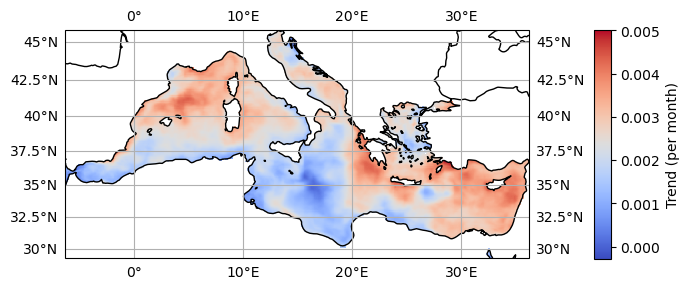

In [5]:
plot_trend_map_stack(z_time)

In [6]:
z_test = helper_functions.preprocessing(
    ds, 
    features=["thetao"], 
    depths=[0], 
    dim="feature", 
    interpolate=-1
)



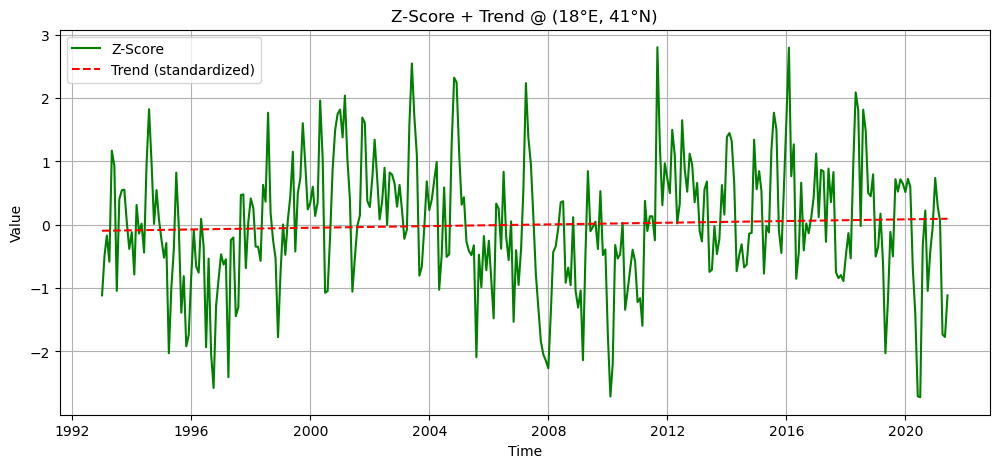

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

feature = "thetao"
depth = 0

original = ds[feature].sel(depth=depth, method="nearest")
original_point = original.sel(longitude=18, latitude=41, method="nearest")

time_index = pd.to_datetime(original_point['time'].values)
months = (time_index.year - time_index.year[0]) * 12 + (time_index.month - time_index.month[0])
months -= months[0]

data_num = original_point.assign_coords(time=("time", months))

fit = data_num.polyfit(dim="time", deg=1)
trend = xr.polyval(data_num['time'], fit.polyfit_coefficients)
trend = trend.assign_coords(time=("time", time_index))

mean = original_point.mean().item()
std = original_point.std().item()
trend_z = (trend - mean) / std

# === ONE figure, both plots ===
fig, ax = plt.subplots(figsize=(12, 5))

# Z-Score point from preprocessed
point.plot(ax=ax, label="Z-Score", color="green")

# Standardized trend
ax.plot(time_index, trend_z, "--", color="red", label="Trend (standardized)")

ax.set_title(f"Z-Score + Trend @ (18°E, 41°N)")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.grid(True)
ax.legend()
plt.show()
